<a href="https://colab.research.google.com/github/ShabibSaleh/DPAM-Nutrition/blob/main/DPAM_Nutrition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Pre-Requisite**

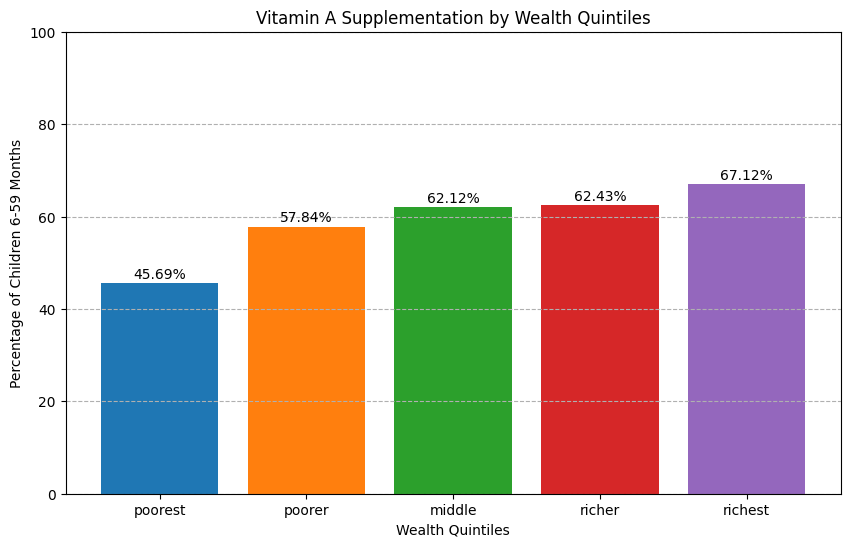

{'National': {'Point Estimate (%)': 61.80877066213974, '95% CI Lower Limit': 61.036348857259945, '95% CI Upper Limit': 62.57526885507214, 'Weighted Sample Size': 8413.90779448578}, 'Wealth Quintile 1 - Poorest': {'Point Estimate (%)': 51.51008960741348, '95% CI Lower Limit': 49.8446109719287, '95% CI Upper Limit': 53.17222095218187, 'Weighted Sample Size': 3563.0634673106356}, 'Wealth Quintile 5 - Richest': {'Point Estimate (%)': 68.27436240751291, '95% CI Lower Limit': 66.68968418379141, '95% CI Upper Limit': 69.8177714042188, 'Weighted Sample Size': 1018.9981738566413}}


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.stats.proportion import proportion_confint

# Load the data
file_path = 'sample_data/VitA.csv'
data = pd.read_csv(file_path)

# Data Cleaning
data_cleaned = data.rename(columns=lambda x: x.strip().replace(" ", "_").lower())
columns_to_drop = data_cleaned.columns[data_cleaned.isnull().sum() > (0.5 * len(data_cleaned))]
data_cleaned = data_cleaned.drop(columns=columns_to_drop)
data_cleaned.drop_duplicates(inplace=True)
categorical_cols = data_cleaned.select_dtypes(include=['object']).columns
data_cleaned[categorical_cols] = data_cleaned[categorical_cols].astype('category')

# Analysis
# Filter data for children aged 6-59 months
age_filtered_data = data_cleaned[(data_cleaned['current_age_of_child'] >= 6) & (data_cleaned['current_age_of_child'] <= 59) & (data_cleaned['whether_child_was_alive_or_dead_at_the_time_of_interview'] == 'yes')]

# Calculate percentages by wealth quintiles
wealth_quintiles = ['poorest', 'poorer', 'middle', 'richer', 'richest']
percentages = []

for quintile in wealth_quintiles:
    quintile_data = age_filtered_data[age_filtered_data['wealth'] == quintile]
    quintile_numerator = quintile_data[quintile_data['received_a_vitamin_a_dose_in_form_of_an_ampoule,_a_capsule_or_syrup_in_last_6_months'] == 'yes'].shape[0]
    quintile_denominator = quintile_data.shape[0]
    quintile_percentage = (quintile_numerator / quintile_denominator) * 100 if quintile_denominator > 0 else 0
    percentages.append(quintile_percentage)

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(wealth_quintiles, percentages, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'])
plt.title('Vitamin A Supplementation by Wealth Quintiles')
plt.xlabel('Wealth Quintiles')
plt.ylabel('Percentage of Children 6-59 Months')
plt.ylim(0, 100)
plt.grid(axis='y', linestyle='--')
for i, v in enumerate(percentages):
    plt.text(i, v + 1, f"{v:.2f}%", ha='center')
plt.show()

# Calculating Point Estimates, Confidence Intervals, and Weighted Sample Sizes
def calculate_weighted_sample_size(data):
    return np.sum(data['sample_weight'])**2 / np.sum(data['sample_weight']**2)

results = {}
for label, dataset in [('National', age_filtered_data), ('Wealth Quintile 1 - Poorest', age_filtered_data[age_filtered_data['wealth'] == 'poorest']), ('Wealth Quintile 5 - Richest', age_filtered_data[age_filtered_data['wealth'] == 'richest'])]:
    numerator = dataset[dataset['received_a_vitamin_a_dose_in_form_of_an_ampoule,_a_capsule_or_syrup_in_last_6_months'] == 'yes']
    point_estimate = (numerator['sample_weight'].sum() / dataset['sample_weight'].sum()) * 100
    lower, upper = proportion_confint(count=numerator['sample_weight'].sum(), nobs=dataset['sample_weight'].sum(), alpha=0.05, method='wilson')
    weighted_sample_size = calculate_weighted_sample_size(dataset)
    results[label] = {
        'Point Estimate (%)': point_estimate,
        '95% CI Lower Limit': lower * 100,
        '95% CI Upper Limit': upper * 100,
        'Weighted Sample Size': weighted_sample_size
    }

print(results)
